# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [3]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [5]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"),
                             input_pipe=None, rot_mult=4)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


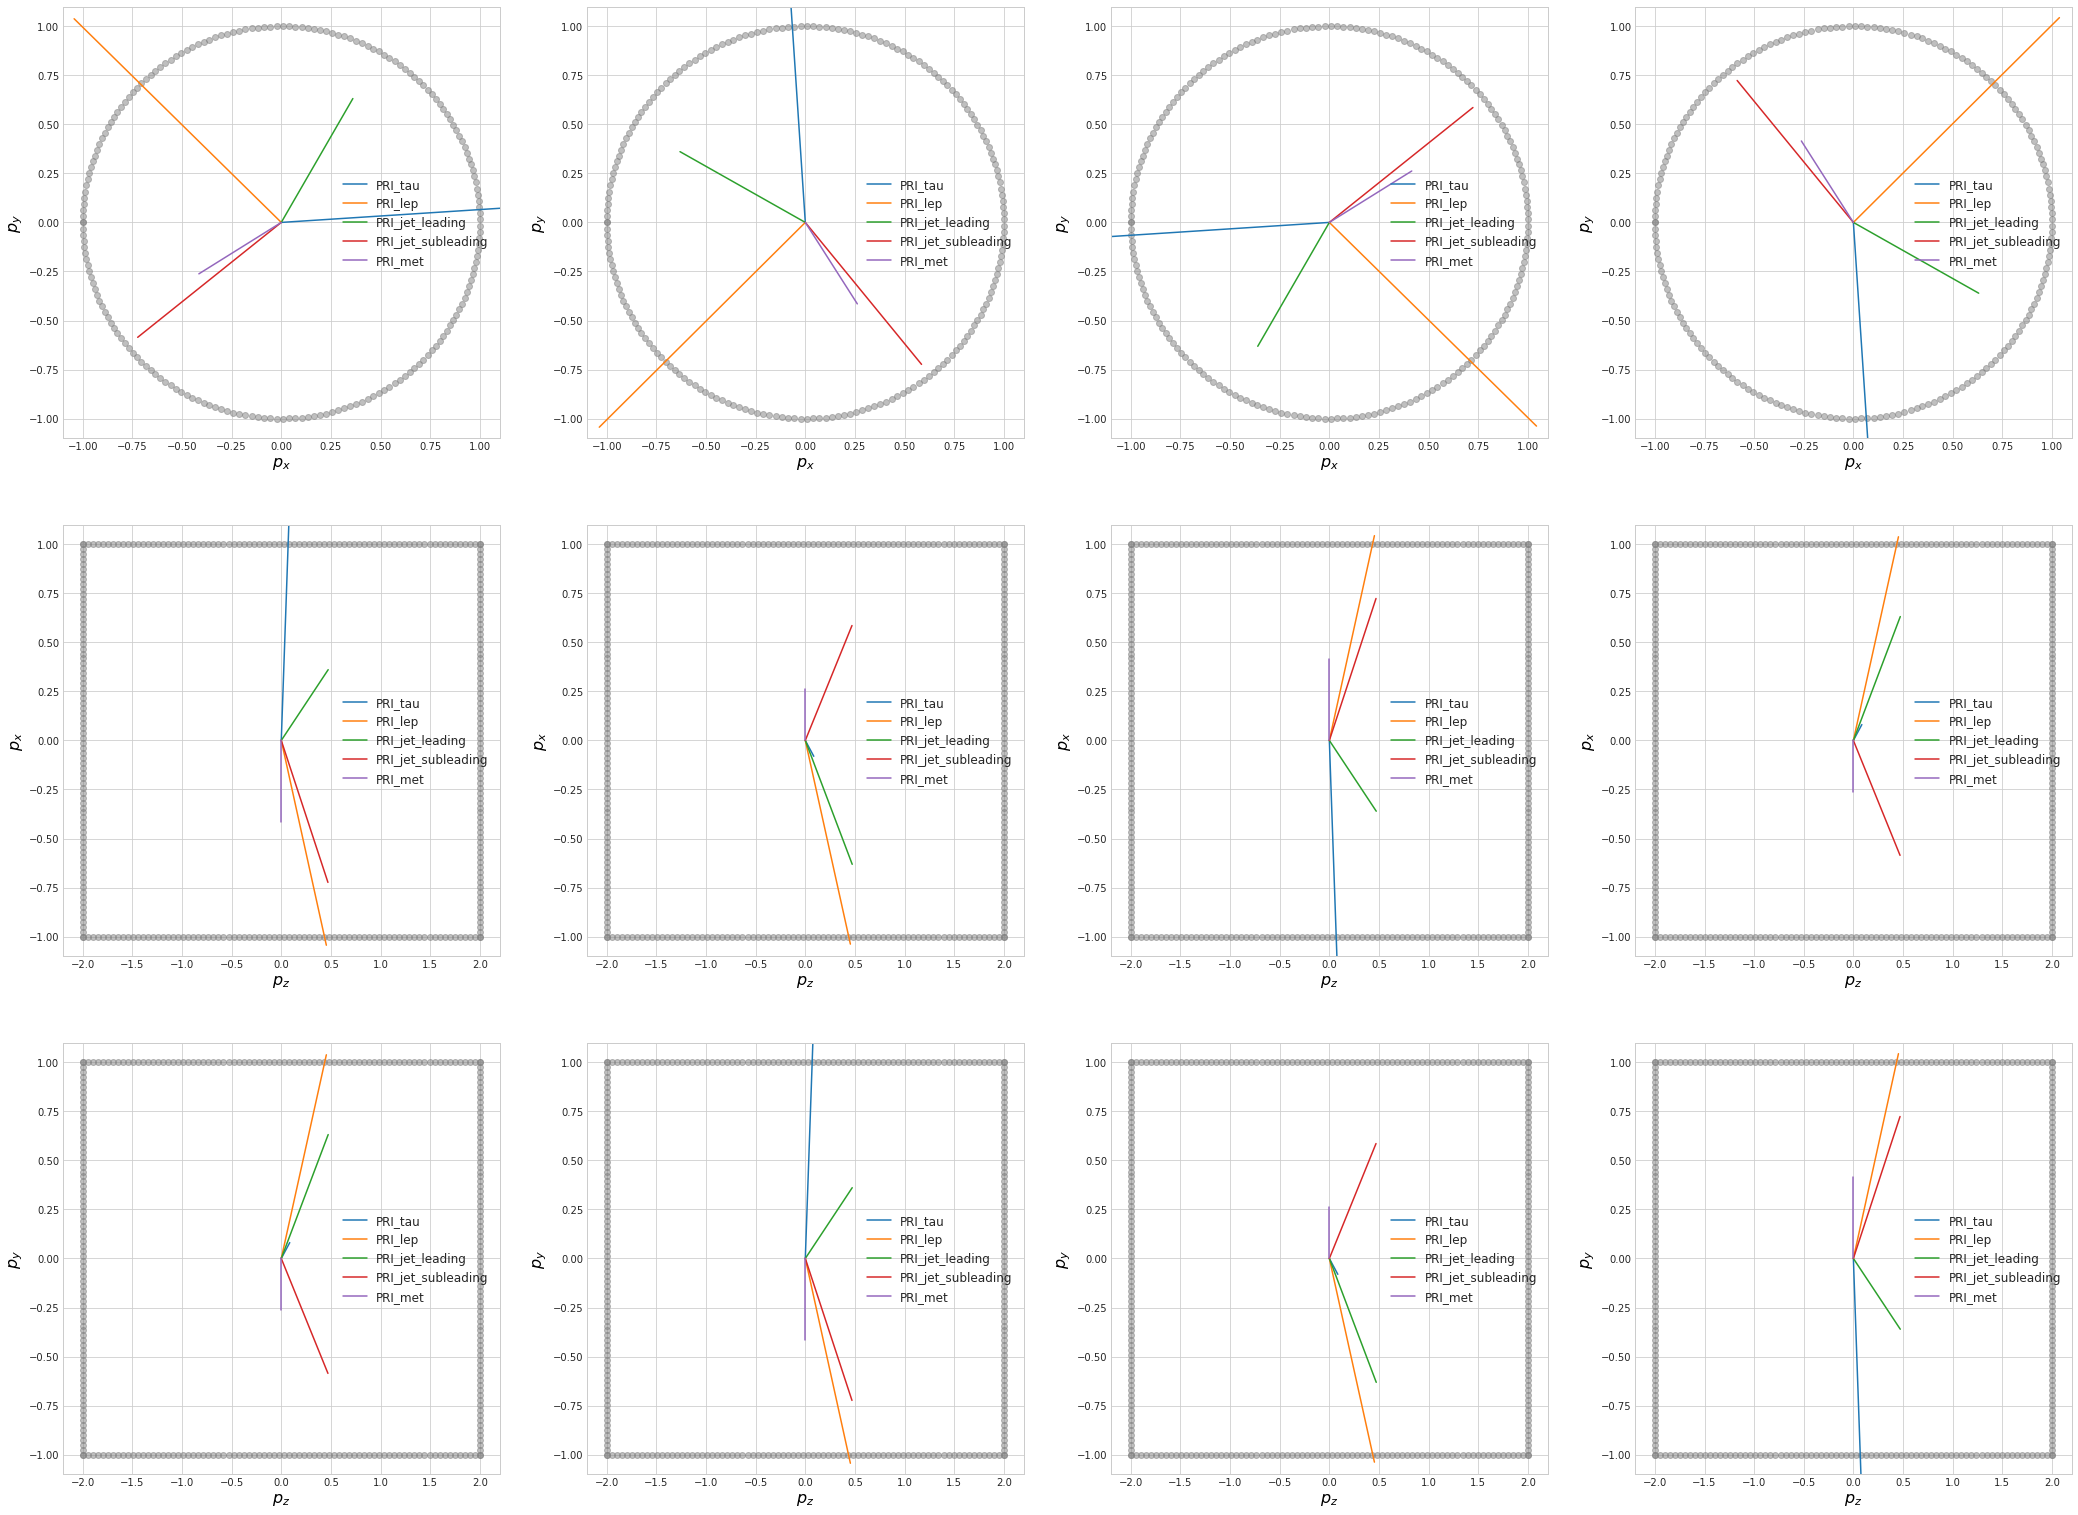

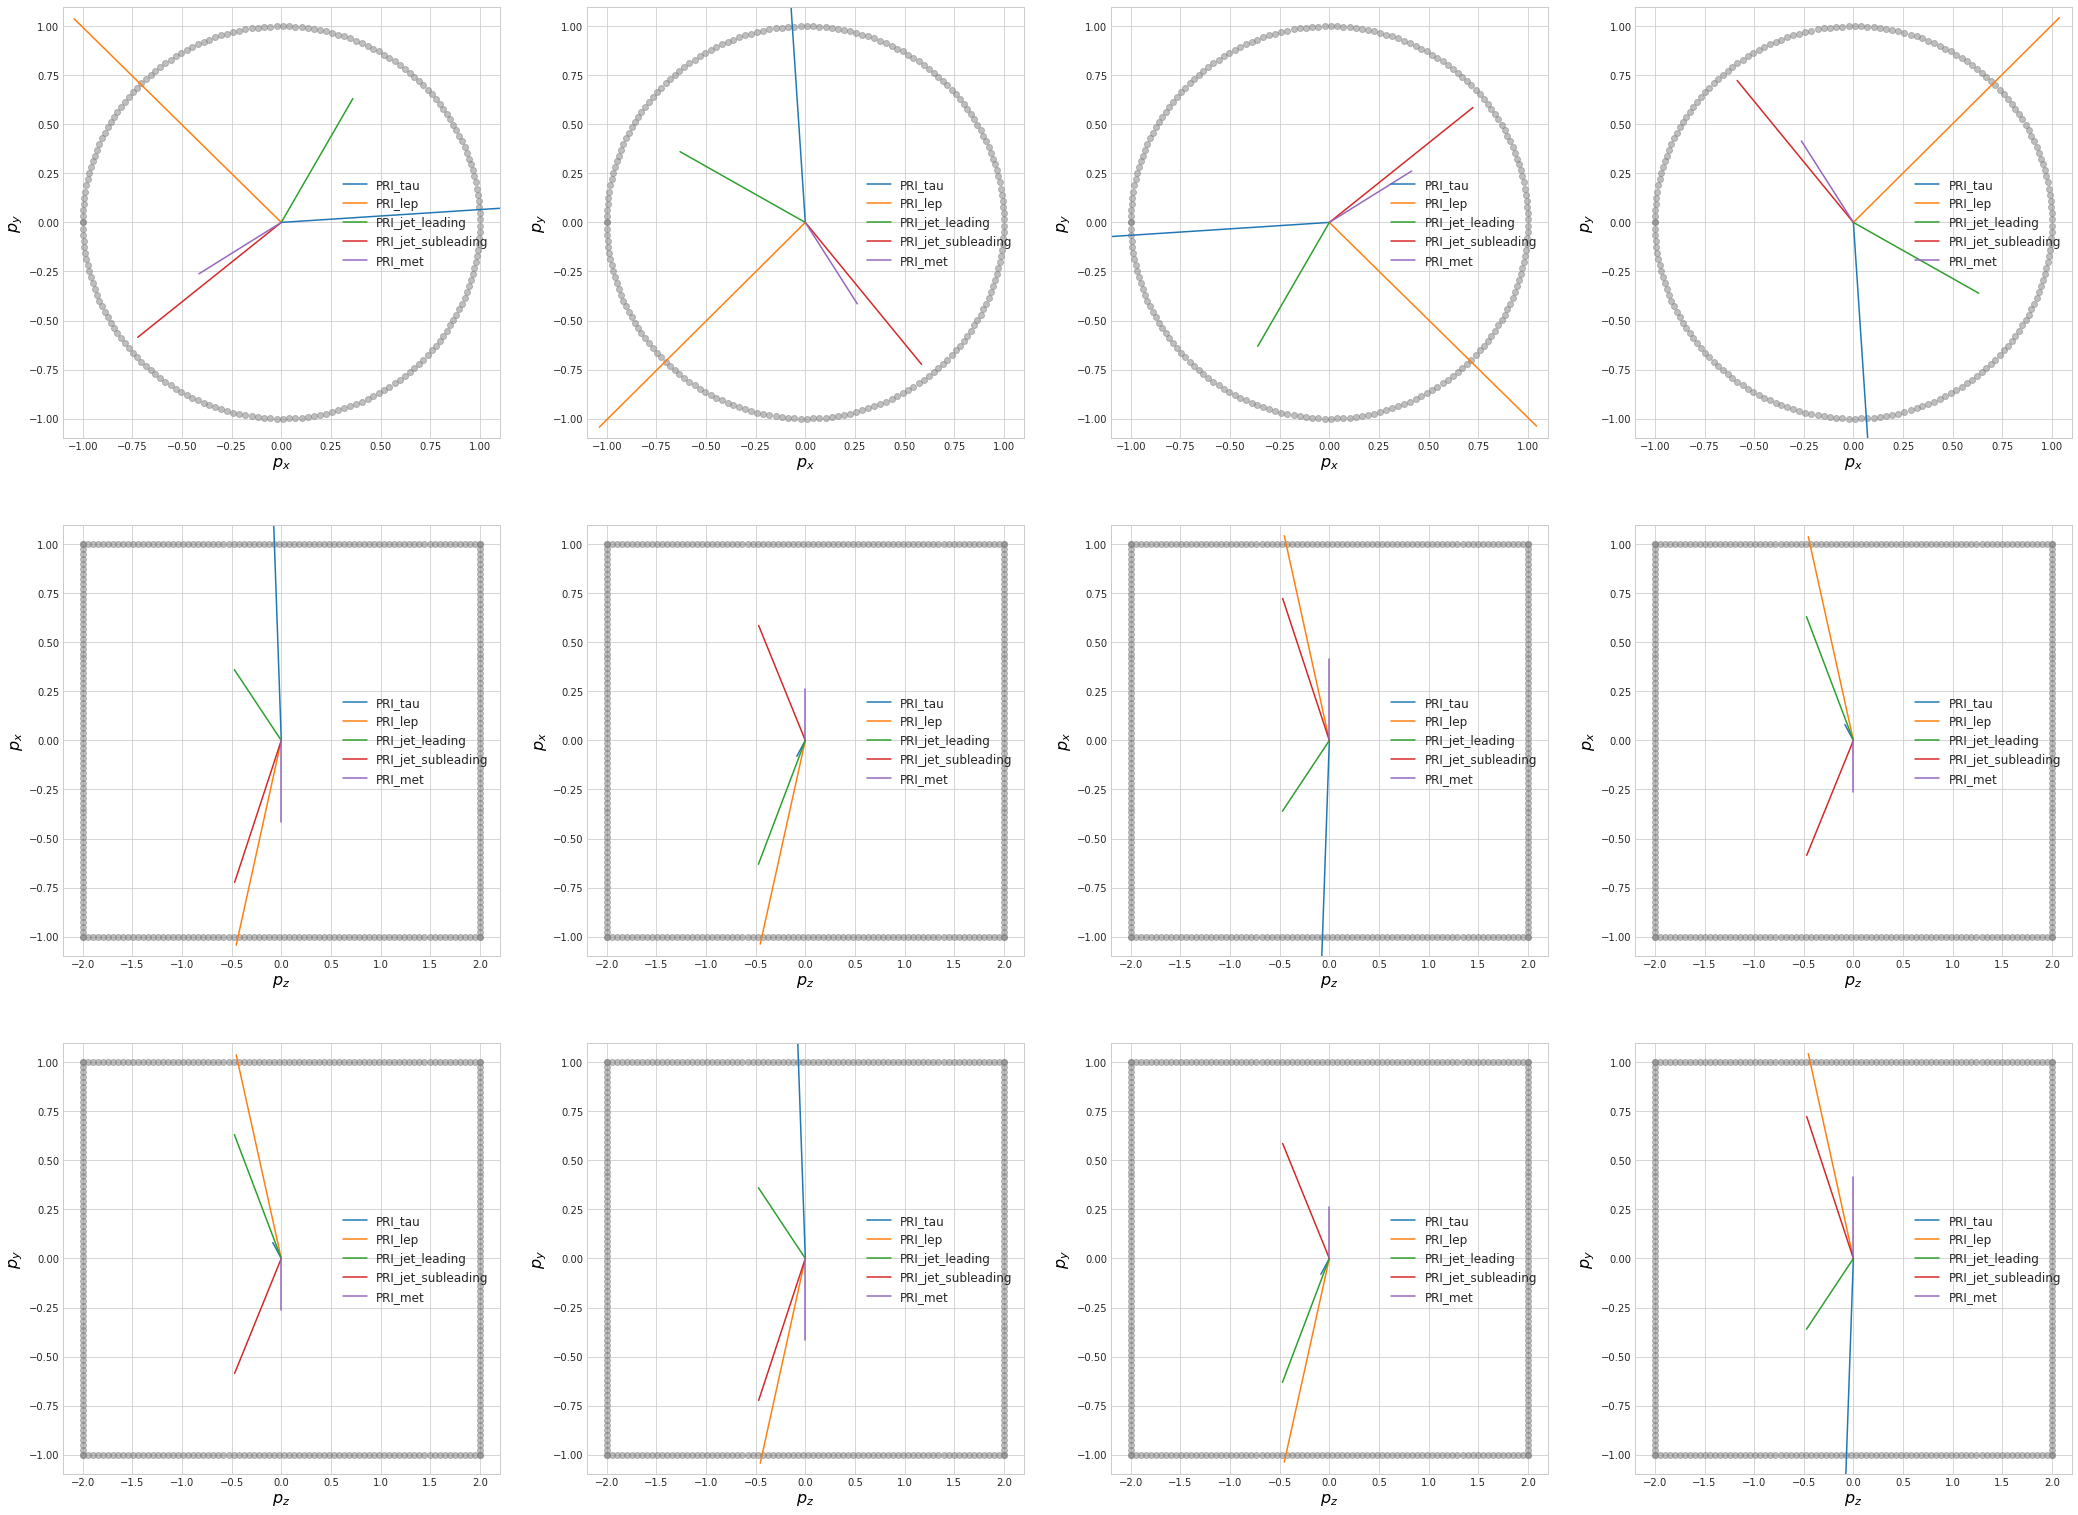

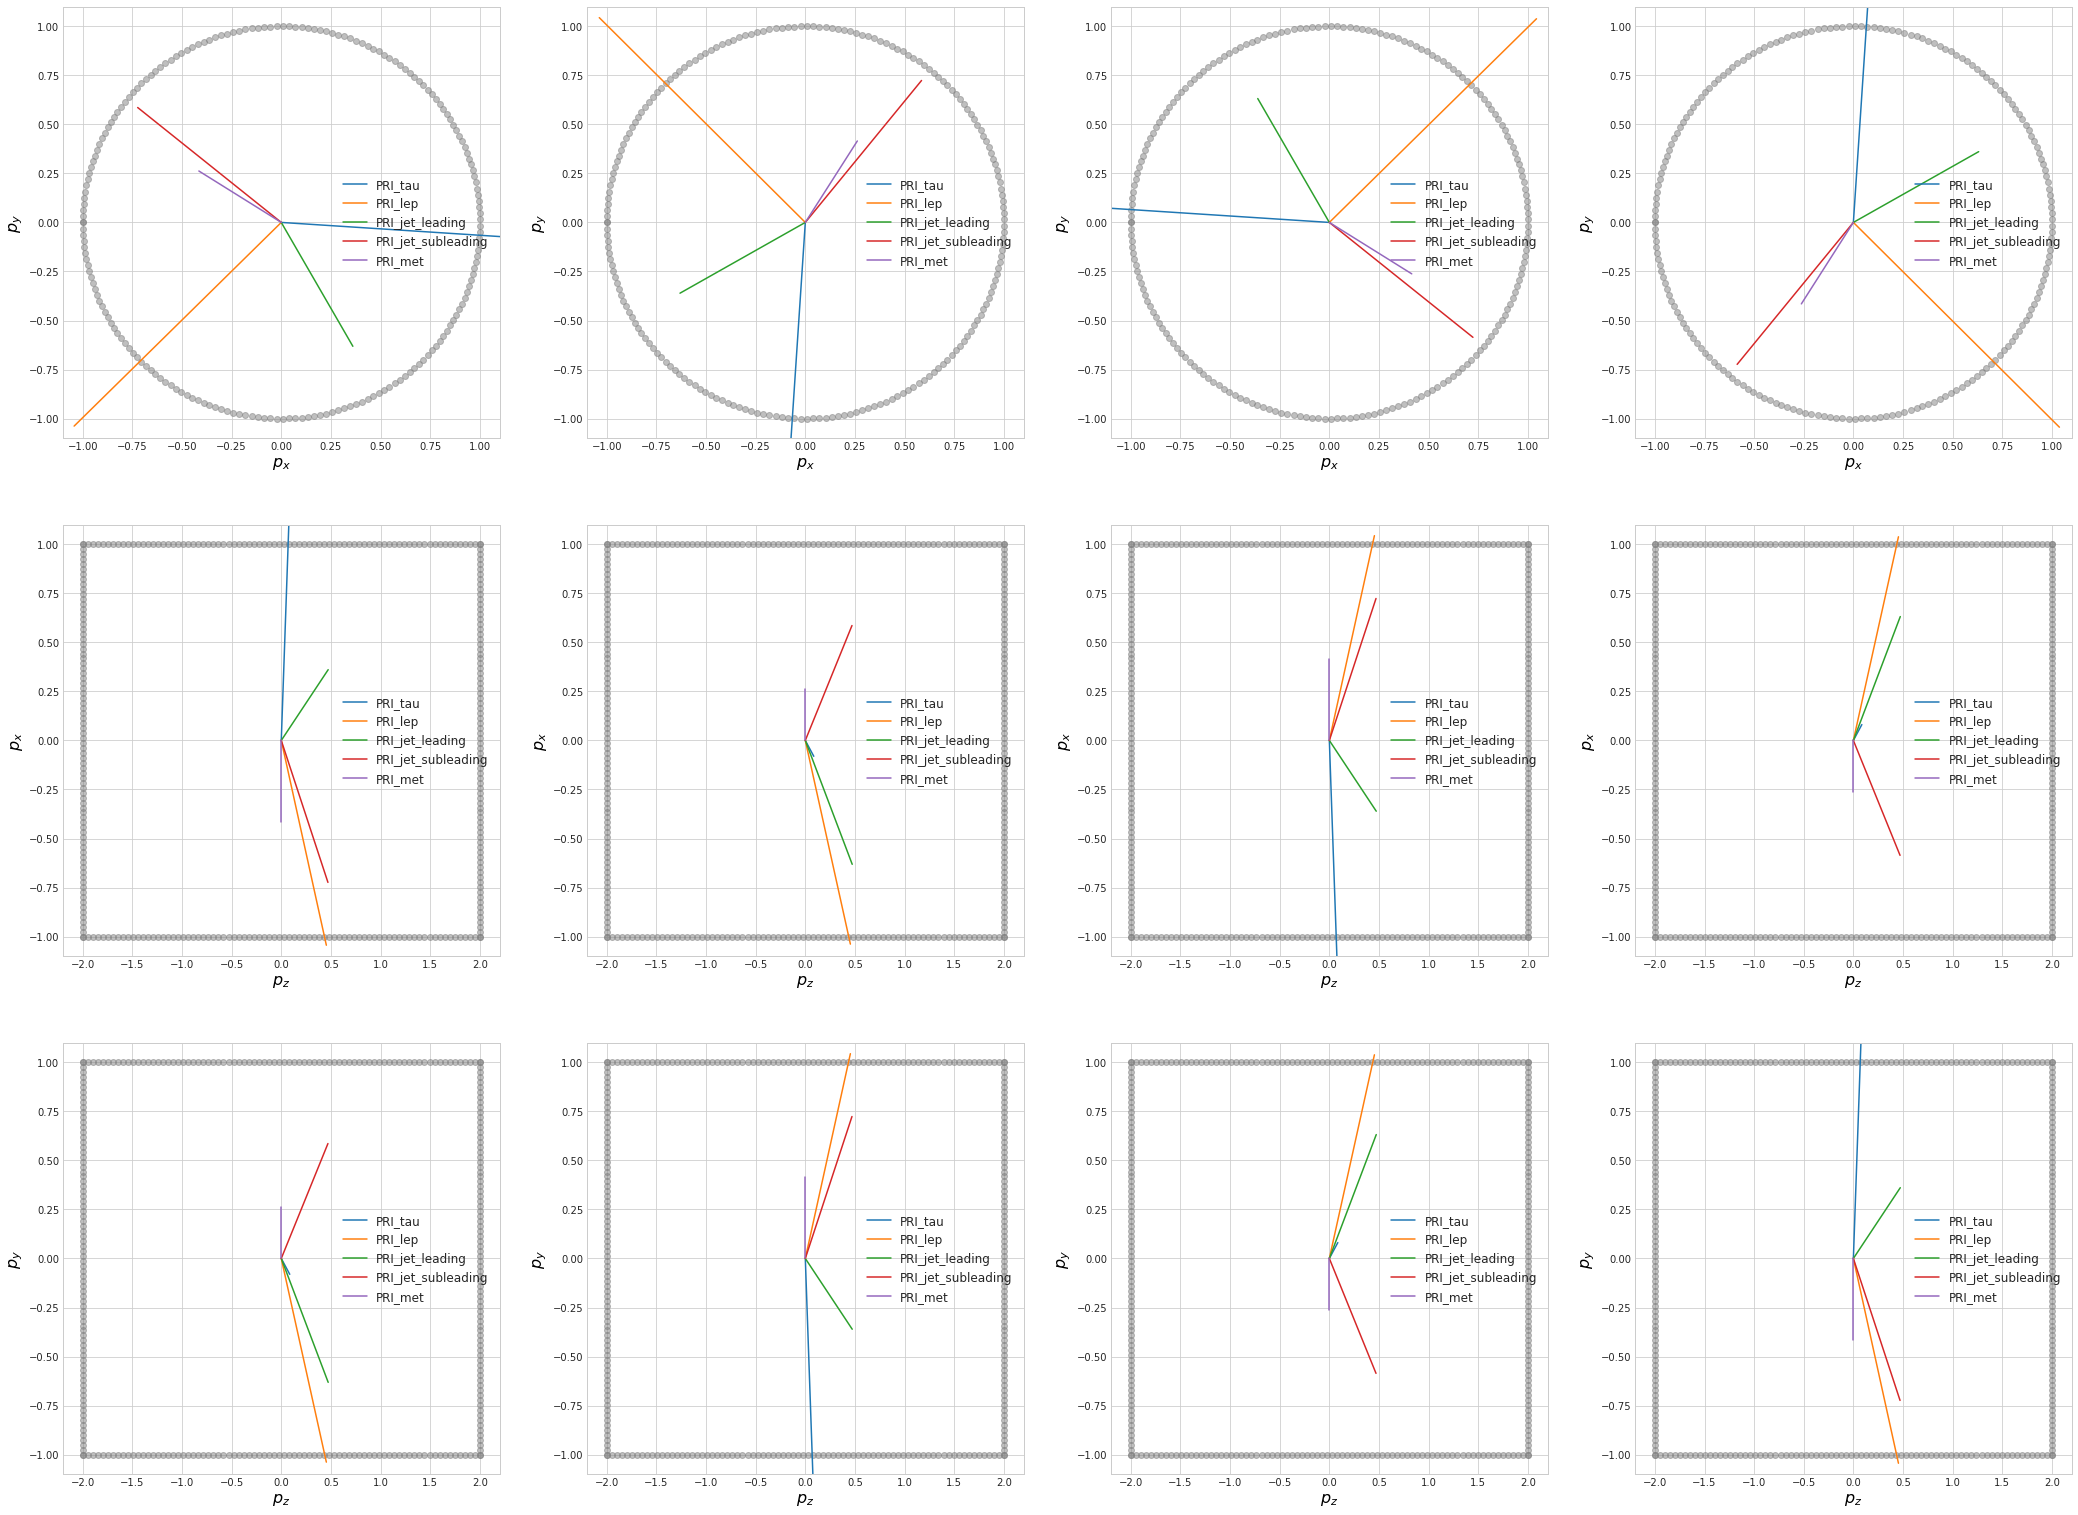

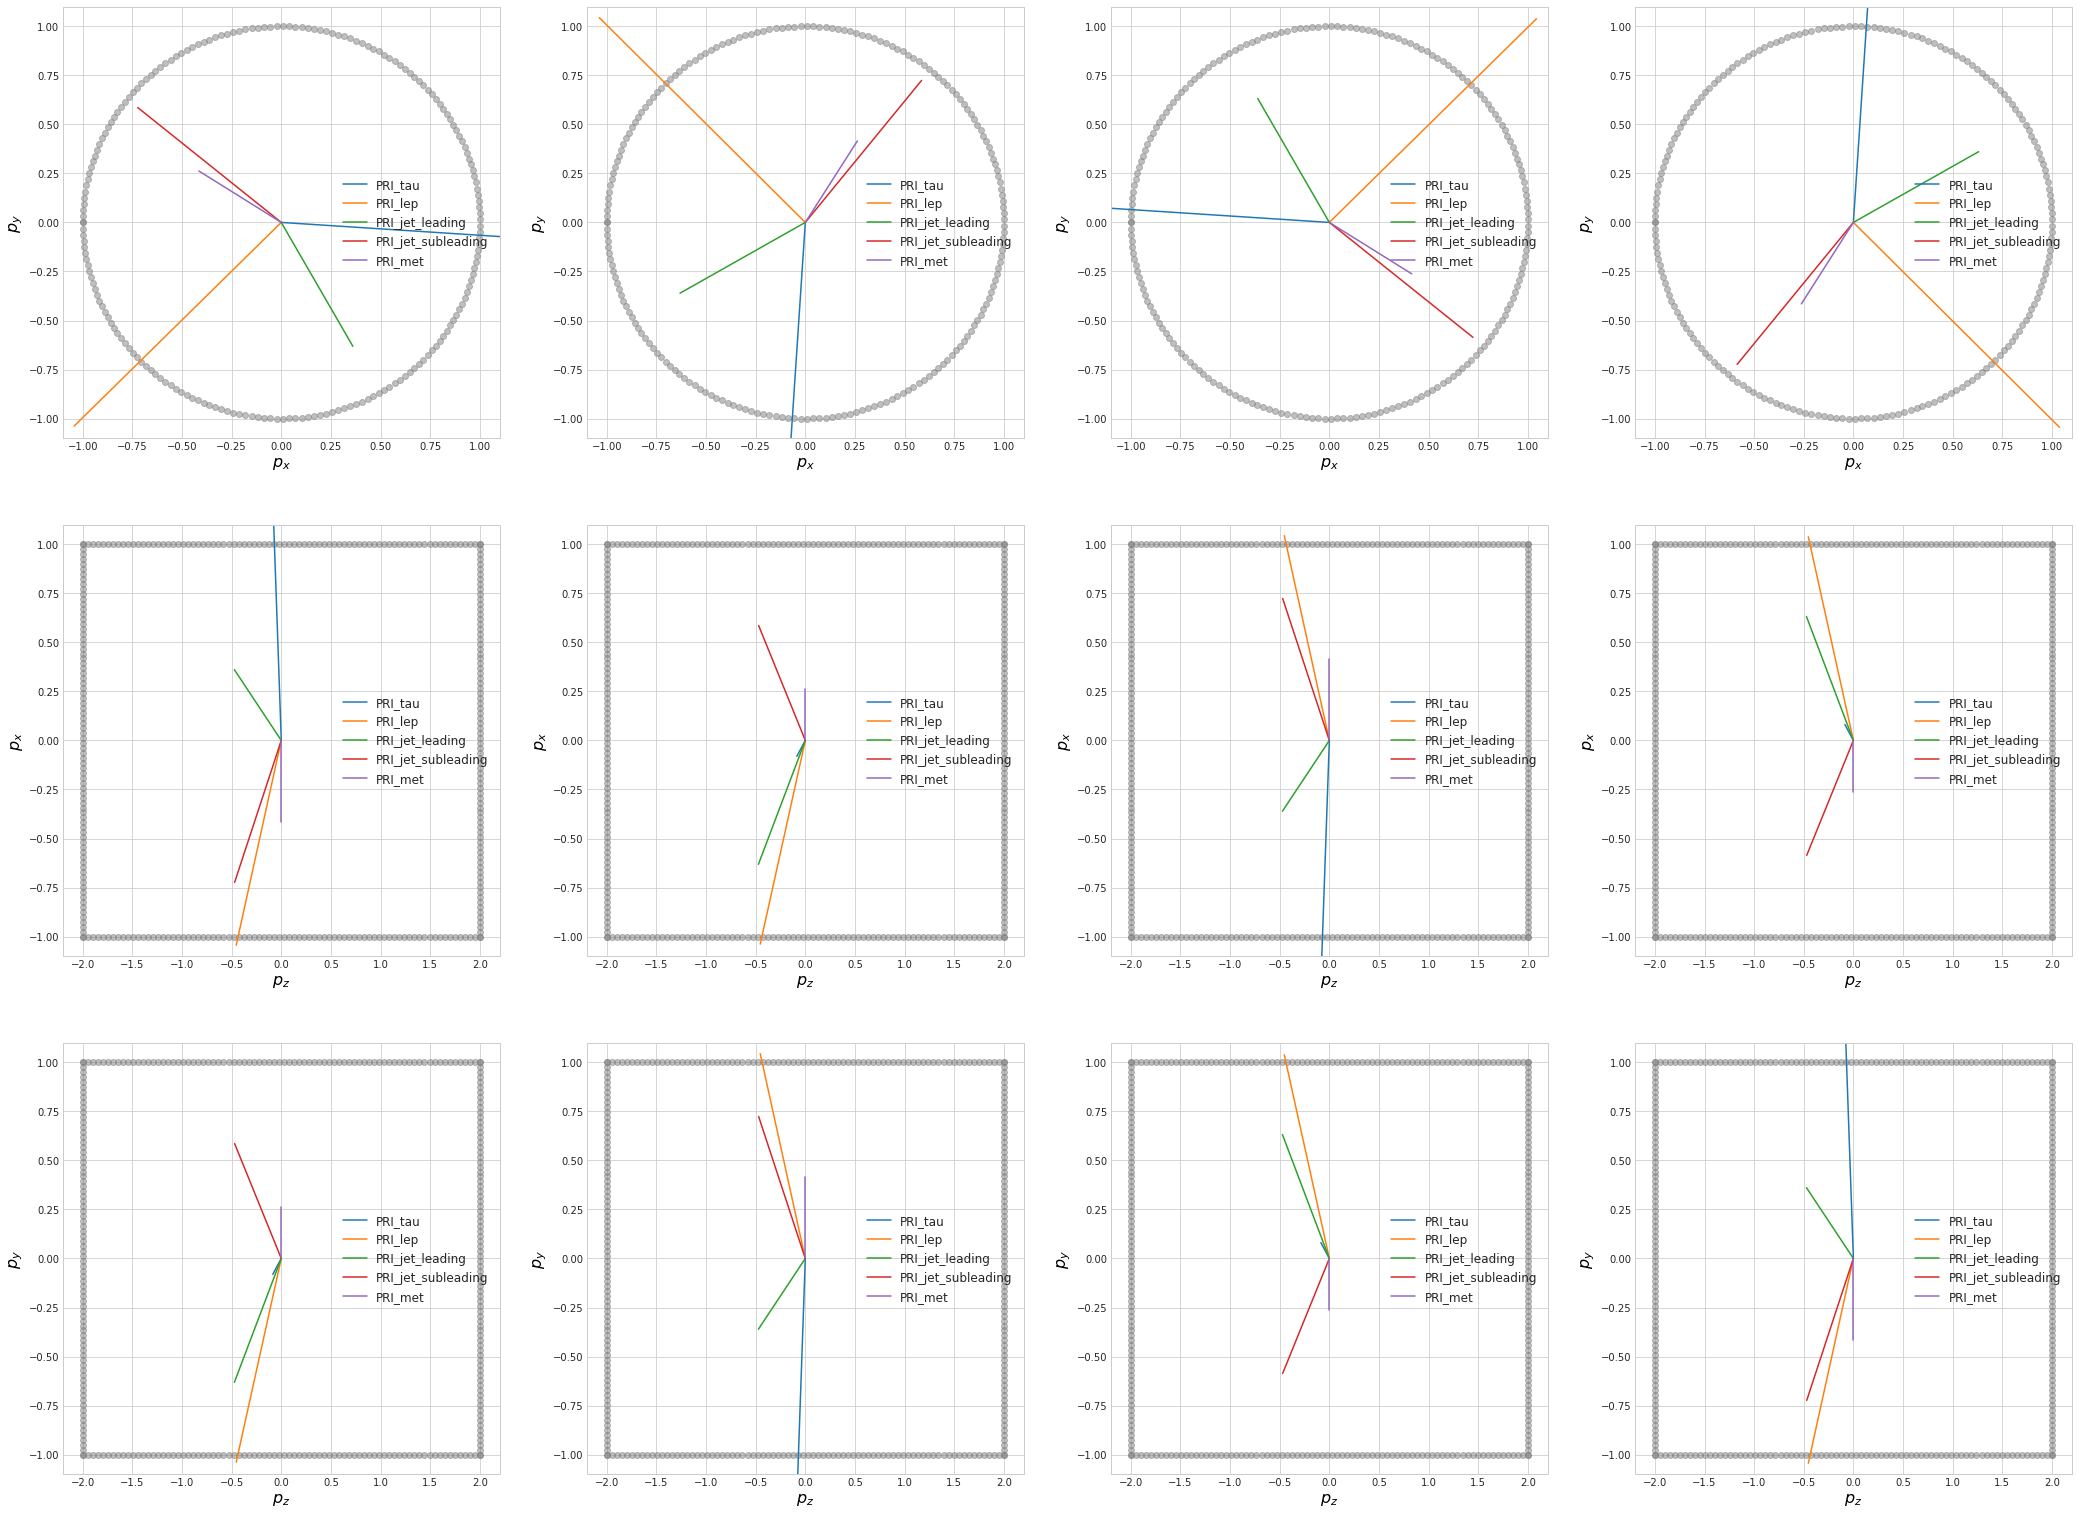

In [6]:
id=3
aug_ranges = [range(4), range(4,8), range(8,12), range(12,16)]
for aug_range in aug_ranges:
    comp_events([pd.DataFrame(train_fy.get_test_fold(0, i)['inputs'], columns=train_feats)[id:id+1] for i in aug_range])

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 16.707s 


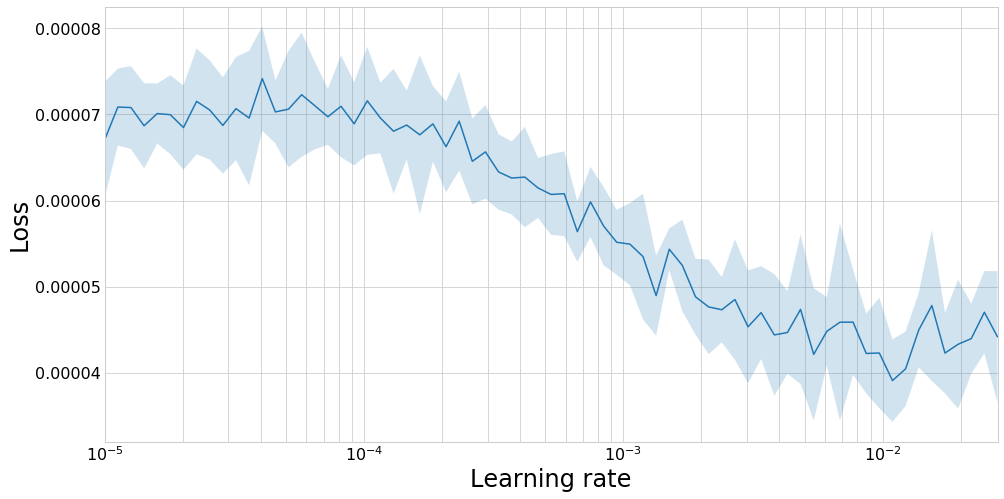

______________________________________



In [7]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [8]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104286). Check your callbacks.
  % delta_t_median)


1 New best found: 4.072759165574098e-05
2 New best found: 3.7636624566221146e-05
3 New best found: 3.6934284195012876e-05
5 New best found: 3.5741217045870143e-05
6 New best found: 3.536511658458039e-05
7 New best found: 3.5110970652021935e-05
9 New best found: 3.4809122765727805e-05
11 New best found: 3.449548971548211e-05
12 New best found: 3.432788849750068e-05
13 New best found: 3.4178941498976204e-05
14 New best found: 3.4177003963850435e-05
15 New best found: 3.4093569708056745e-05
22 New best found: 3.391178344900254e-05
23 New best found: 3.3642810949822886e-05
27 New best found: 3.352283231361071e-05
28 New best found: 3.341243419563398e-05
29 New best found: 3.334095467143925e-05
30 New best found: 3.333264047687408e-05
31 New best found: 3.332841423980426e-05
49 New best found: 3.326787864498329e-05
51 New best found: 3.3199188942671755e-05
54 New best found: 3.312063081539236e-05
55 New best found: 3.3051440965209625e-05
56 New best found: 3.2981637711054646e-05
58 New best

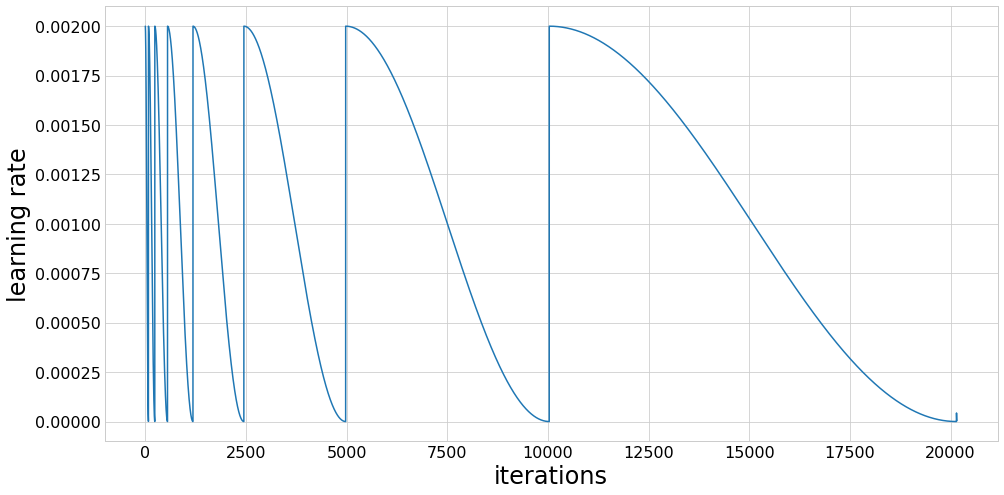

Fold took 233.694s

Training model 2 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244007). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122346). Check your callbacks.
  % delta_t_median)


1 New best found: 4.042094129836187e-05
2 New best found: 3.6720419277844486e-05
3 New best found: 3.602697300811997e-05
4 New best found: 3.505478382576257e-05
5 New best found: 3.481526378600392e-05
6 New best found: 3.391627299715765e-05
7 New best found: 3.38898339192383e-05
11 New best found: 3.3452855513314715e-05
12 New best found: 3.325496972393012e-05
13 New best found: 3.2933224232692735e-05
14 New best found: 3.280437341018114e-05
15 New best found: 3.274693600251339e-05
23 New best found: 3.266692858596798e-05
24 New best found: 3.234442426619353e-05
25 New best found: 3.228447418514406e-05
26 New best found: 3.22255106526427e-05
28 New best found: 3.2064204945345407e-05
29 New best found: 3.202302040008362e-05
30 New best found: 3.201978065917501e-05
48 New best found: 3.1966916302917526e-05
49 New best found: 3.184549597499427e-05
51 New best found: 3.184295444661984e-05
52 New best found: 3.181692443904467e-05
54 New best found: 3.177532121771946e-05
55 New best found: 3

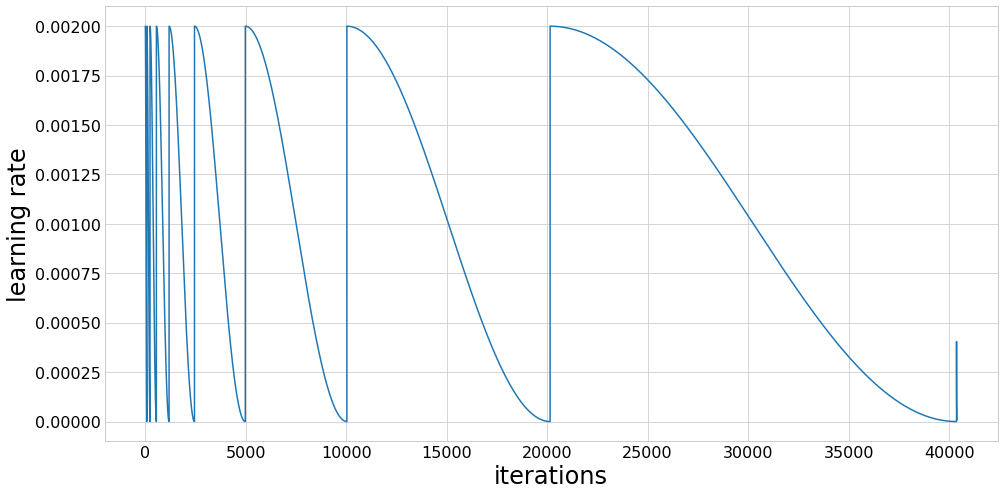

Fold took 468.011s

Training model 3 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250203). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125443). Check your callbacks.
  % delta_t_median)


1 New best found: 4.040522607974708e-05
2 New best found: 3.731390215689316e-05
3 New best found: 3.622122759988997e-05
4 New best found: 3.5623090443550606e-05
5 New best found: 3.4886964919860476e-05
6 New best found: 3.43930064511369e-05
7 New best found: 3.4320529270917177e-05
9 New best found: 3.426806803036015e-05
11 New best found: 3.392689153697575e-05
12 New best found: 3.3769651564216475e-05
13 New best found: 3.333755518833641e-05
15 New best found: 3.331647657760186e-05
21 New best found: 3.3219765491230646e-05
22 New best found: 3.316966186830541e-05
23 New best found: 3.298854258318897e-05
24 New best found: 3.288244716532063e-05
25 New best found: 3.2722618606931064e-05
28 New best found: 3.2689451528858626e-05
29 New best found: 3.2637895525840575e-05
30 New best found: 3.262763854436343e-05
31 New best found: 3.2621869842841986e-05
49 New best found: 3.253393378618057e-05
51 New best found: 3.238169086398557e-05
53 New best found: 3.235876990875113e-05
54 New best foun

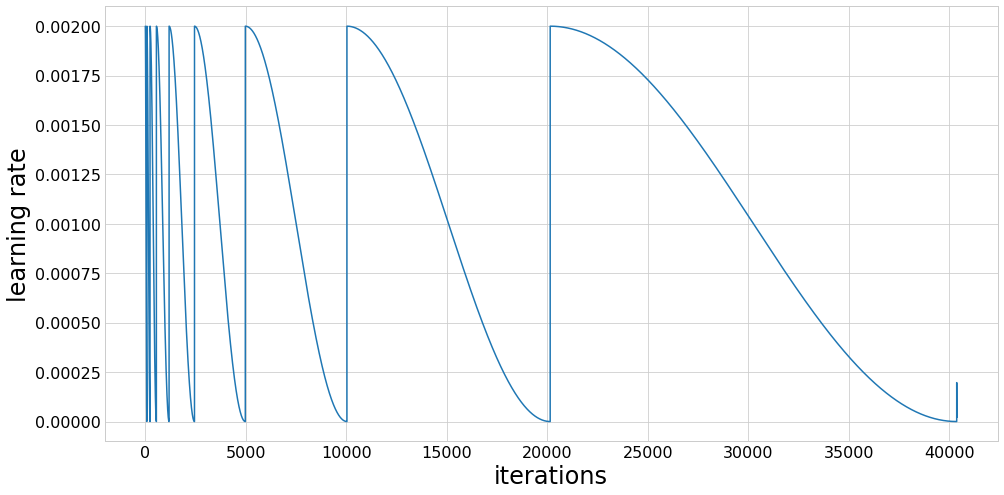

Fold took 467.954s

Training model 4 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.285002). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142871). Check your callbacks.
  % delta_t_median)


1 New best found: 3.906877695217e-05
2 New best found: 3.6042850759076473e-05
3 New best found: 3.552383286861176e-05
4 New best found: 3.5084086686071656e-05
5 New best found: 3.494777538265234e-05
6 New best found: 3.395353176815737e-05
7 New best found: 3.377066612715296e-05
10 New best found: 3.3717766048046885e-05
11 New best found: 3.343663936185421e-05
12 New best found: 3.328878862270516e-05
13 New best found: 3.29893384754884e-05
14 New best found: 3.283540863064481e-05
15 New best found: 3.281555485927403e-05
24 New best found: 3.270273261556345e-05
25 New best found: 3.238961273887864e-05
26 New best found: 3.23462842859186e-05
27 New best found: 3.2288791220917384e-05
28 New best found: 3.222006103561597e-05
29 New best found: 3.216329899268066e-05
30 New best found: 3.2146185274018655e-05
47 New best found: 3.211509883512479e-05
48 New best found: 3.211185147919919e-05
49 New best found: 3.204430702709577e-05
50 New best found: 3.18826878281474e-05
51 New best found: 3.185

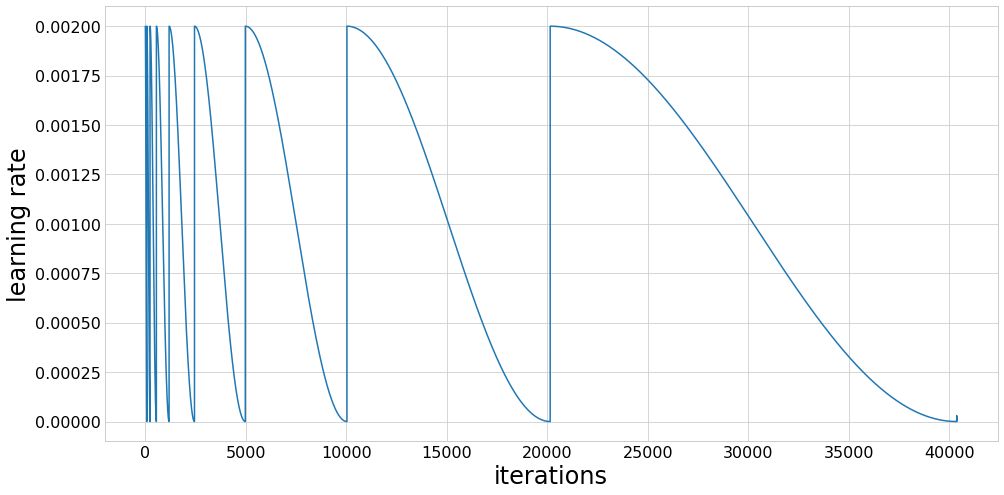

Fold took 479.807s

Training model 5 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.301723). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151205). Check your callbacks.
  % delta_t_median)


1 New best found: 3.995525517977235e-05
2 New best found: 3.808914174577506e-05
3 New best found: 3.664689647026576e-05
4 New best found: 3.663937235477586e-05
5 New best found: 3.598472721942016e-05
6 New best found: 3.526244141379001e-05
7 New best found: 3.514735071058604e-05
11 New best found: 3.467453877346683e-05
12 New best found: 3.438152166527963e-05
13 New best found: 3.421168274233055e-05
14 New best found: 3.4088661812687026e-05
15 New best found: 3.4066160525157507e-05
22 New best found: 3.3876438858945534e-05
23 New best found: 3.378732303365055e-05
24 New best found: 3.37102383410624e-05
26 New best found: 3.366445429096822e-05
28 New best found: 3.3545721126372854e-05
29 New best found: 3.347749668997133e-05
48 New best found: 3.3323116567014985e-05
50 New best found: 3.3228408606253875e-05
52 New best found: 3.3185387806326374e-05
55 New best found: 3.3063253833254666e-05
58 New best found: 3.303382048035346e-05
59 New best found: 3.3016356788280266e-05
60 New best fou

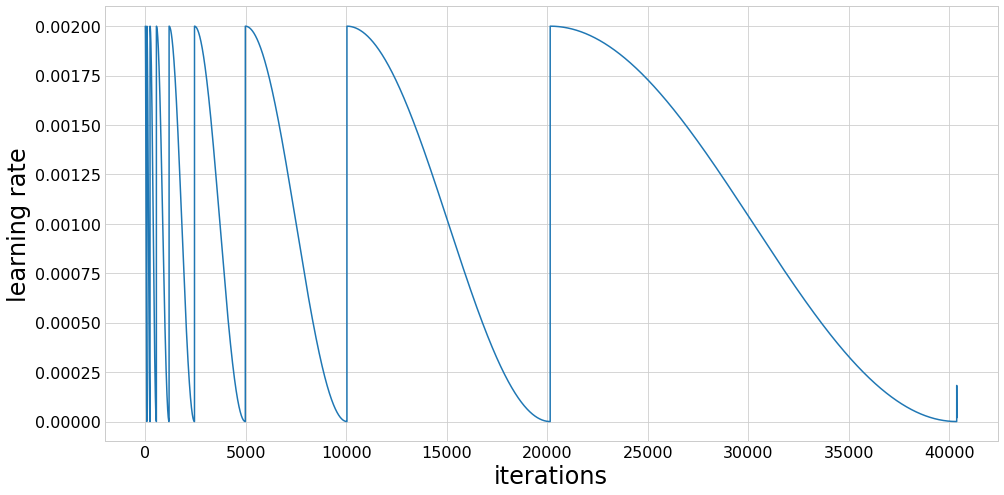

Fold took 486.316s

Training model 6 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.316022). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158348). Check your callbacks.
  % delta_t_median)


1 New best found: 3.8781446699048844e-05
2 New best found: 3.645992282004447e-05
3 New best found: 3.541708655541195e-05
4 New best found: 3.523175238057817e-05
5 New best found: 3.4152954963024274e-05
6 New best found: 3.373639712085213e-05
7 New best found: 3.372303548374649e-05
10 New best found: 3.3537004335095265e-05
11 New best found: 3.307077418879817e-05
12 New best found: 3.3054061333167785e-05
13 New best found: 3.2698147988045074e-05
14 New best found: 3.257620836502093e-05
15 New best found: 3.253522976617388e-05
23 New best found: 3.246217045515906e-05
24 New best found: 3.2251988240117906e-05
27 New best found: 3.205411307844987e-05
28 New best found: 3.200688546479511e-05
29 New best found: 3.200394294087337e-05
30 New best found: 3.195016597715045e-05
31 New best found: 3.1948863960015766e-05
49 New best found: 3.191688738710602e-05
52 New best found: 3.187496605695808e-05
55 New best found: 3.1794431476060096e-05
56 New best found: 3.174555379862485e-05
59 New best fou

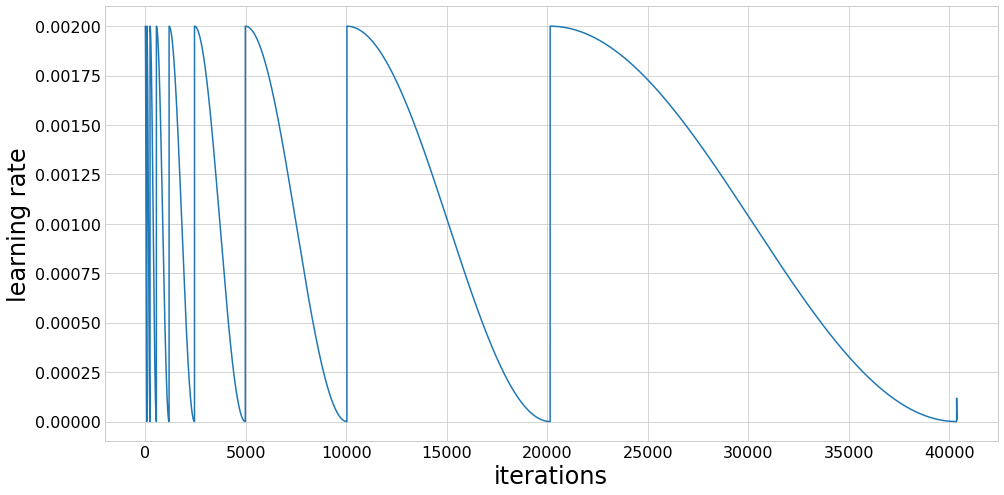

Fold took 496.791s

Training model 7 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.319349). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160246). Check your callbacks.
  % delta_t_median)


1 New best found: 3.8955297408686615e-05
2 New best found: 3.67554637656119e-05
3 New best found: 3.531090990418429e-05
4 New best found: 3.474215876610912e-05
6 New best found: 3.3632625496957485e-05
7 New best found: 3.358363080244863e-05
9 New best found: 3.351553420450587e-05
10 New best found: 3.3058922071232655e-05
11 New best found: 3.286674277796244e-05
12 New best found: 3.269918897069566e-05
13 New best found: 3.251864255806195e-05
14 New best found: 3.239678786253341e-05
24 New best found: 3.231152211912018e-05
25 New best found: 3.206688056416382e-05
27 New best found: 3.197494487193054e-05
28 New best found: 3.195584302725291e-05
29 New best found: 3.190414753285889e-05
50 New best found: 3.167930851086874e-05
52 New best found: 3.16360466333722e-05
54 New best found: 3.1620454147969725e-05
55 New best found: 3.159734620683418e-05
59 New best found: 3.153056443417089e-05
60 New best found: 3.150737335542385e-05
61 New best found: 3.149774478609475e-05
62 New best found: 3.

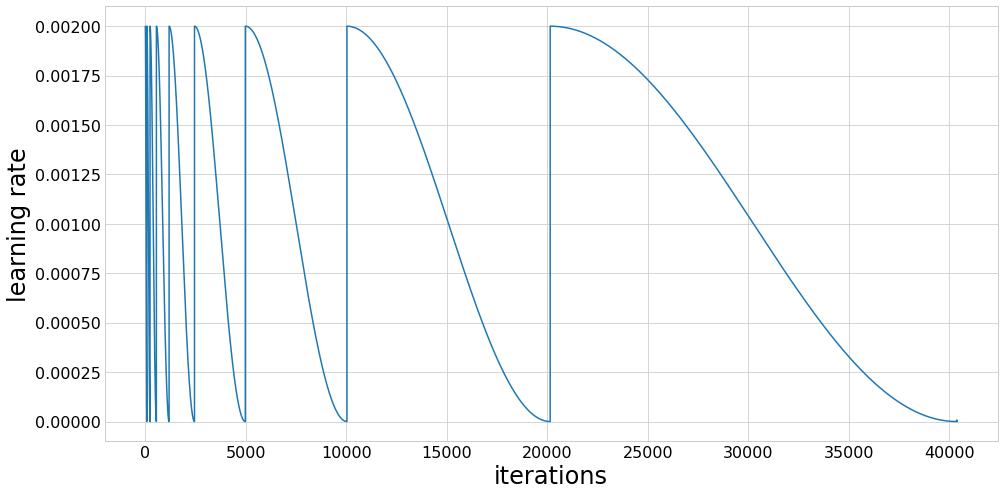

Fold took 502.821s

Training model 8 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.365589). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183145). Check your callbacks.
  % delta_t_median)


1 New best found: 3.85181633608452e-05
2 New best found: 3.658315982354937e-05
3 New best found: 3.525719138023693e-05
4 New best found: 3.4826072104680355e-05
5 New best found: 3.403522600405019e-05
6 New best found: 3.352955511762621e-05
7 New best found: 3.3458294967675214e-05
10 New best found: 3.324818302689166e-05
11 New best found: 3.324798018969971e-05
12 New best found: 3.2817650441495824e-05
14 New best found: 3.248265756600153e-05
15 New best found: 3.244781349532032e-05
23 New best found: 3.239043330495622e-05
24 New best found: 3.208158112336071e-05
26 New best found: 3.1992134436396105e-05
27 New best found: 3.198214420296755e-05
28 New best found: 3.1902076705968665e-05
29 New best found: 3.188283554738568e-05
30 New best found: 3.186351535785606e-05
31 New best found: 3.185984879247401e-05
51 New best found: 3.159377772790218e-05
55 New best found: 3.15890629211932e-05
56 New best found: 3.1561824121063863e-05
57 New best found: 3.142170162665493e-05
59 New best found: 

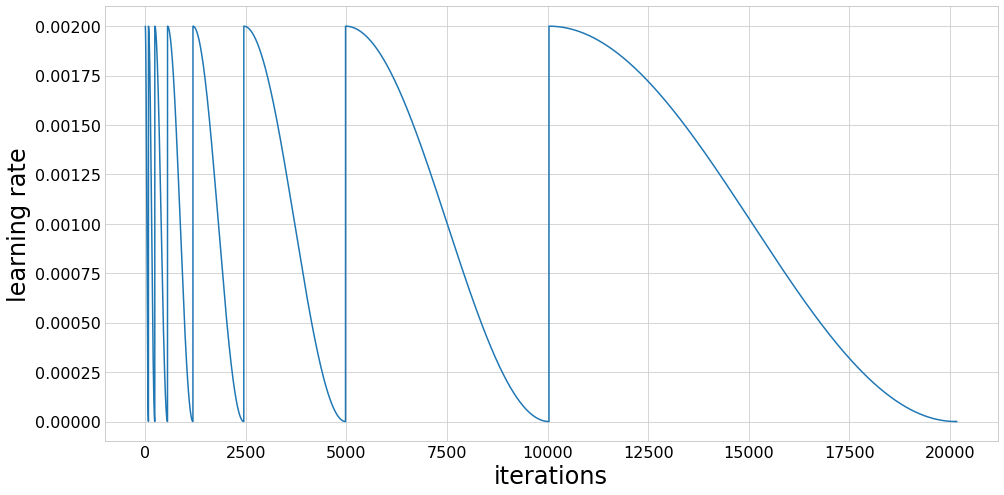

Fold took 276.953s

Training model 9 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.430305). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215524). Check your callbacks.
  % delta_t_median)


1 New best found: 4.0605071606114506e-05
2 New best found: 3.7156402671826074e-05
3 New best found: 3.6634737221174876e-05
4 New best found: 3.6391896028362683e-05
5 New best found: 3.559793245949549e-05
6 New best found: 3.503928367426852e-05
7 New best found: 3.474751149769873e-05
11 New best found: 3.440257962356554e-05
12 New best found: 3.401620607619407e-05
13 New best found: 3.384560105041601e-05
14 New best found: 3.368449031113414e-05
15 New best found: 3.36345696952776e-05
22 New best found: 3.357600581366569e-05
24 New best found: 3.3529132038529494e-05
25 New best found: 3.335824778914684e-05
26 New best found: 3.328149095905246e-05
27 New best found: 3.31244171858998e-05
29 New best found: 3.307646361499792e-05
30 New best found: 3.304904353281017e-05
31 New best found: 3.304632449726341e-05
48 New best found: 3.303324856969993e-05
52 New best found: 3.2930037450569215e-05
53 New best found: 3.284300447703572e-05
54 New best found: 3.2833112803928086e-05
56 New best found:

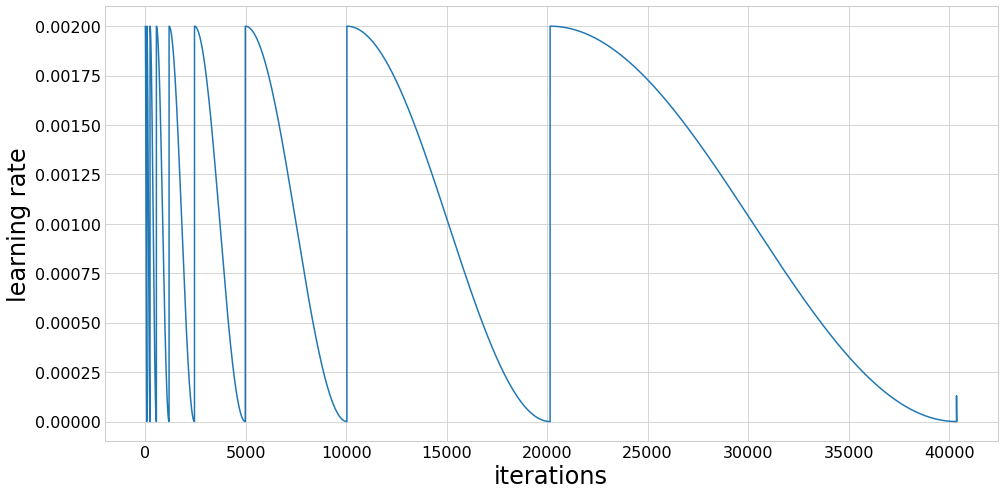

Fold took 528.236s

Training model 10 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.433414). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217085). Check your callbacks.
  % delta_t_median)


1 New best found: 3.967758850731453e-05
2 New best found: 3.7171687071251706e-05
3 New best found: 3.646491739492914e-05
4 New best found: 3.59102241079671e-05
5 New best found: 3.541374636070456e-05
6 New best found: 3.48075956262107e-05
7 New best found: 3.471073005501675e-05
11 New best found: 3.468064959990925e-05
12 New best found: 3.4254927533350765e-05
13 New best found: 3.391114029313651e-05
14 New best found: 3.3773462438300106e-05
15 New best found: 3.375853399967722e-05
22 New best found: 3.3589990252045985e-05
25 New best found: 3.355976511948146e-05
27 New best found: 3.3502909518957475e-05
28 New best found: 3.334230937512735e-05
29 New best found: 3.331423440972212e-05
30 New best found: 3.330860885822655e-05
31 New best found: 3.3304185109965054e-05
45 New best found: 3.3281670110805924e-05
49 New best found: 3.3110870560122444e-05
50 New best found: 3.299696133064279e-05
54 New best found: 3.294736017907683e-05
56 New best found: 3.2928044195001697e-05
57 New best foun

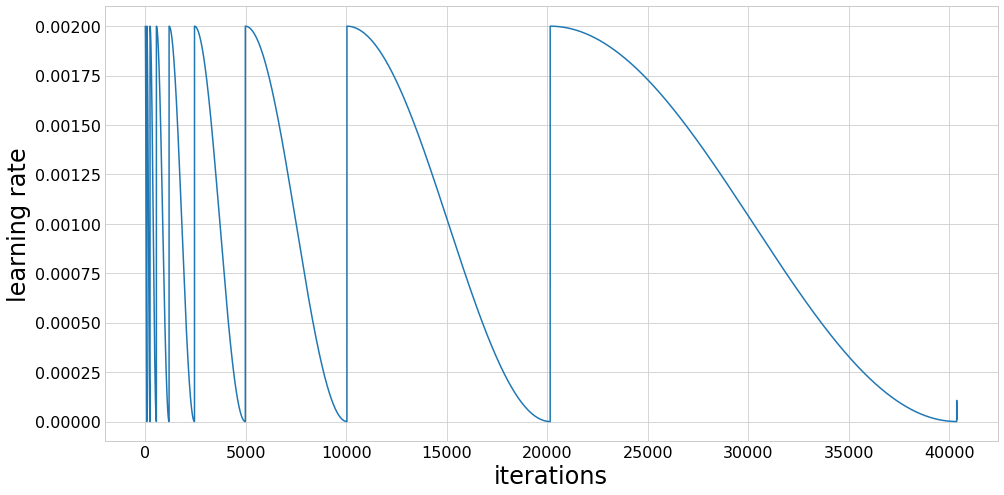

Fold took 530.386s


______________________________________
Training finished
Cross-validation took 4473.921s 


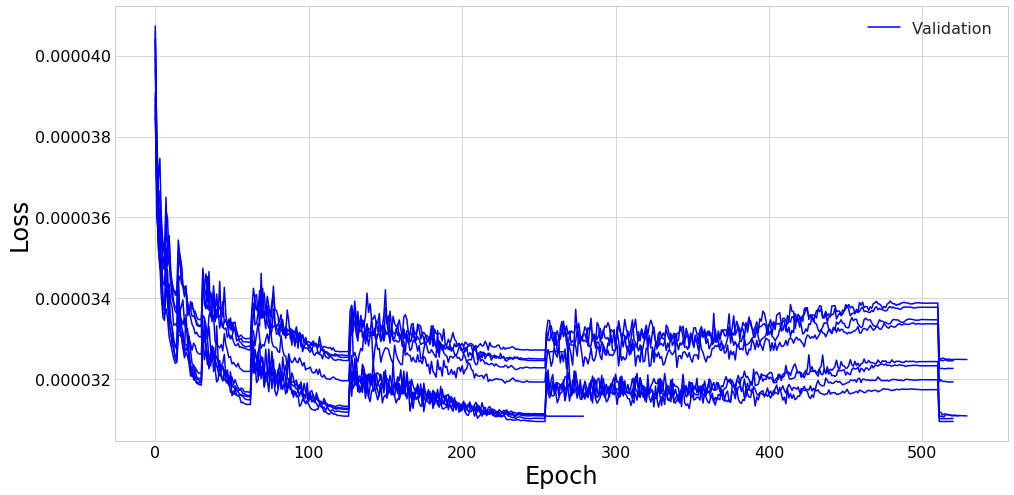

Mean loss = 3.17e-05 +- 2e-07
Mean wAUC = 0.063 +- 0.0009
Mean AUC = 0.0981 +- 0.0007
Mean AMS = 4.0 +- 0.1
Mean cut = 0.962 +- 0.006
______________________________________



<Figure size 432x288 with 0 Axes>

In [9]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

## Construct ensemble

In [10]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [11]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 6 with loss = 3.095794084346969e-05
Model 1 is 3 with loss = 3.102529718494179e-05
Model 2 is 5 with loss = 3.107279004361591e-05
Model 3 is 7 with loss = 3.1089667379400787e-05
Model 4 is 1 with loss = 3.10950908518862e-05
Model 5 is 2 with loss = 3.1906245445134116e-05
Model 6 is 9 with loss = 3.223834424639521e-05
Model 7 is 4 with loss = 3.245220038653897e-05
Model 8 is 8 with loss = 3.2486477399652356e-05
Model 9 is 0 with loss = 3.2674403135024473e-05


## Response on validation data without TTA

In [12]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [13]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.001827279419824481s per sample

Predicting fold 2 out of 10
Prediction took 0.0003274798424914479s per sample

Predicting fold 3 out of 10
Prediction took 0.0003279882322996855s per sample

Predicting fold 4 out of 10
Prediction took 0.0003363719953224063s per sample

Predicting fold 5 out of 10
Prediction took 0.0003365215903148055s per sample

Predicting fold 6 out of 10
Prediction took 0.00033741683550179004s per sample

Predicting fold 7 out of 10
Prediction took 0.0003315155794844031s per sample

Predicting fold 8 out of 10
Prediction took 0.00033227839339524507s per sample

Predicting fold 9 out of 10
Prediction took 0.00033345266450196504s per sample

Predicting fold 10 out of 10
Prediction took 0.00033013222478330136s per sample



In [14]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

Testing ROC AUC: unweighted 0.9036752159079859, weighted 0.936173396078011


In [15]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

50000 candidates loaded


(3.9832581854347557, 0.96105814)

In [16]:
%%time
cut = bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)[1]

50000 candidates loaded

Mean calc_ams=4.0+-0.2, at mean cut of 0.96+-0.01
Exact mean cut 0.9633875949075446, corresponds to calc_ams of 3.9140050769310792
CPU times: user 2.46 s, sys: 13.8 s, total: 16.3 s
Wall time: 2min 8s


## Response on validation data with TTA

In [17]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"),
                           input_pipe=None, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32


In [18]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.011579405656456947s per sample

Predicting fold 2 out of 10
Prediction took 0.01150638537351042s per sample

Predicting fold 3 out of 10
Prediction took 0.011530763918720186s per sample

Predicting fold 4 out of 10
Prediction took 0.011584256877750158s per sample

Predicting fold 5 out of 10
Prediction took 0.011562723437696695s per sample

Predicting fold 6 out of 10
Prediction took 0.011585261679627002s per sample

Predicting fold 7 out of 10
Prediction took 0.011531788143701852s per sample

Predicting fold 8 out of 10
Prediction took 0.011559883049316703s per sample

Predicting fold 9 out of 10
Prediction took 0.011588128482922911s per sample

Predicting fold 10 out of 10
Prediction took 0.01154898831732571s per sample



In [19]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

Testing ROC AUC: unweighted 0.9038596491383428, weighted 0.9362994743962298


In [20]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

50000 candidates loaded


(3.964159502661793, 0.9616161)

In [21]:
%%time
tta_cut = bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)[1]

50000 candidates loaded

Mean calc_ams=4.0+-0.2, at mean cut of 0.96+-0.01
Exact mean cut 0.9646541421534494, corresponds to calc_ams of 3.8428516336199148
CPU times: user 2.55 s, sys: 15.1 s, total: 17.7 s
Wall time: 2min 7s


# Test scoring - Without TTA

In [55]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [56]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0003421999213878404s per sample

Predicting fold 2 out of 10
Prediction took 0.00034348933075300673s per sample

Predicting fold 3 out of 10
Prediction took 0.0003446005112406882s per sample

Predicting fold 4 out of 10
Prediction took 0.0003446776044978337s per sample

Predicting fold 5 out of 10
Prediction took 0.000343360308219086s per sample

Predicting fold 6 out of 10
Prediction took 0.0003425481566143307s per sample

Predicting fold 7 out of 10
Prediction took 0.0003454020350663499s per sample

Predicting fold 8 out of 10
Prediction took 0.0003433415767821399s per sample

Predicting fold 9 out of 10
Prediction took 0.00034400910022245213s per sample

Predicting fold 10 out of 10
Prediction took 0.0003443190047517419s per sample

CPU times: user 3min 23s, sys: 11.8 s, total: 3min 35s
Wall time: 3min 9s


In [57]:
score_test_data(test_fy.source, 0.9633875949075446)

Public:Private AMS: 3.6629743111119213 : 3.7436856522253077


(3.6629743111119213, 3.7436856522253077)

# Test scoring - With TTA

In [25]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"),
                            input_pipe=None, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32


In [26]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0111848602860658s per sample

Predicting fold 2 out of 10
Prediction took 0.011157339030944489s per sample

Predicting fold 3 out of 10
Prediction took 0.011149086529829285s per sample

Predicting fold 4 out of 10
Prediction took 0.011170693827268074s per sample

Predicting fold 5 out of 10
Prediction took 0.011197825063832781s per sample

Predicting fold 6 out of 10
Prediction took 0.011189629815654321s per sample

Predicting fold 7 out of 10
Prediction took 0.011159476873414082s per sample

Predicting fold 8 out of 10
Prediction took 0.011167716773159125s per sample

Predicting fold 9 out of 10
Prediction took 0.011173985683579336s per sample

Predicting fold 10 out of 10
Prediction took 0.01119389735976742s per sample

CPU times: user 1h 49min 59s, sys: 6min 30s, total: 1h 56min 30s
Wall time: 1h 42min 25s


In [54]:
score_test_data(test_fy.source, 0.9646541421534494)

Public:Private AMS: 3.6313675982630103 : 3.7349205609656893


(3.6313675982630103, 3.7349205609656893)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)